# Miniproyecto 3 - Resolviendo Frozen Lake <a class="anchor" id="inicio"></a>

### Winston Pernett - Gina Martinez

En este notebook veremos una manera de resolver el ambiente de Frozen Lake, para que un agente pueda llegar a su destino al menos el 80% de las veces. Para ello hacemos uso de la clase Q-Learning que corresponde a un agente, el cual se va a ir entrenando a partir de la regla Q-learning que permite a un agente aprender a tomar decisiones óptimas en un entorno de toma de decisiones. El objetivo de esta regla es aprender una política de acción que maximice la recompensa total esperada del agente a lo largo del tiempo.

# Dependencias

Al iniciar el notebook o reiniciar el kerner se pueden cargar todas las dependencias de este notebook corriendo las siguientes celdas. Este también es el lugar para instalar las dependencias que podrían hacer falta.

**De Python:**

In [1]:
# En linux o mac
#!pip3 install -r requirements.txt
#!pip3 install gymnasium[toy-text]


# !python -m pip install -r requirements.txt
# !python -m pip install gymnasium[toy-text]
# !python -m pip install termcolor
# !python -m pip install torch
# !python -m pip install moviepy


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored, cprint

c:\Users\winst\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Del notebook:**

In [8]:
from agents import Agent
from algoritmos import *
from utils import Episode, Experiment, gym_interpreter1
from plot_utils import PlotGridValues, Plot
from tests import *
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.wrappers import TimeLimit

---

Se realiza la implementación de la regla Q-learning. 

<img src="./imagenes/q_learning_agent.png" width="450"/>

In [10]:
class Q_learning(Agent) :
    '''
    Implements a Q-learning rule.
    '''

    def __init__(self, parameters:dict):
        super().__init__(parameters)
        self.alpha = self.parameters['alpha']
        self.debug = False
    def update(self, next_state, reward, done):
        '''
        Agent updates its model.
        '''
        
        state = self.states[-1] # Aquí estado previo
        action = self.actions[-1] # Aquí acción previa
        
        
        maxQ = self.max_Q(next_state) 
        
        estimate = reward + (self.gamma * maxQ) # Calcula el estimado

        delta = estimate - self.Q[state, action] # Calcula el delta
        
        prev_Q = self.Q[state, action]
        self.Q[state, action] = prev_Q + self.alpha * delta # Actualiza el valor
        # Update policy
        self.update_policy(state) # Actualizar la política en el estado        
        if self.debug:
            print('')
            print(dash_line)
            print(f'Learning log:')
            print(f'state:{state}')
            print(f'action:{action}')
            print(f'reward:{reward}')
            print(f'estimate:{estimate}')
            print(f'Previous Q:{prev_Q}')
            print(f'delta:{delta}')
            print(f'New Q:{self.Q[state, action]}') 
 

In [11]:
# Creamos nuestro entorno inicial
frozen = gym.make('FrozenLake-v1', 
               desc=["SFFF", "FFHF", "FHFF", "FFFG"], 
               map_name="4x4",
               is_slippery=True, 
               render_mode='rgb_array')

#Definimos los parámetros del agente
parameters = {
    "nS": 16,
    "nA": 4,
    "gamma":1,
    "epsilon":0.1,\
    "alpha":0.1
}

# Creamos el agente con base en los parámetros
agent = Q_learning(parameters=parameters)


#Creamos el episodio que corresponde  a una función del modulo utils
episode = Episode(environment=frozen,\
                          env_name="Frozen",\
                          agent=agent,\
                          model_name='Q_Learning',\
                          num_rounds=200,\
                          state_interpreter=gym_interpreter1
                          )
# Entrenamos el agente con 1500 episodios
df = episode.simulate(num_episodes=1500)



  0%|          | 0/1500 [00:00<?, ?it/s]

<Axes: xlabel='Episode', ylabel='Total reward'>

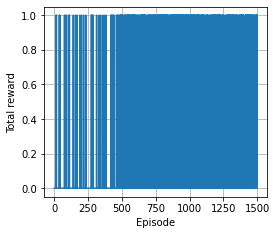

In [12]:
# Graficamos los resultados
p =  Plot(df)

p.plot_rewards(file="file.png") # Grafica las recompensas totales obtenidas en cada episodio. La recompensa es 1 si llega a la meta, cualquier otra accion es 0
 

In [13]:
agent.policy # Política final despues de entrenar. Observamos los valores de la tabla Q para las diferentes acciones
#Por ejemplo para el estado 0, la acción 0 tiene el valor más alto, por lo que la política es 0

array([[0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.03333333, 0.03333333, 0.03333333, 0.9       ],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.9       , 0.03333333, 0.03333333, 0.03333333],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.03333333, 0.03333333, 0.9       , 0.03333333],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.03333333, 0.9       , 0.03333333, 0.03333333],
       [0.25      , 0.25      , 0.25      , 0.25      ]])

Durante el proceso de aprendizaje, queremos que el agente pruebe distintos cursos de acción, de manera tal que tenga una mayor confianza en que está llegando a una política óptima. No obstante, a la hora de poner a marchar al agente en producción, queremos que el agente tenga su mejor desempeño. Para ello, necesitamos poner su parámetro $\epsilon$ en 0. 

In [14]:
# Eliminamos la exploración

agent.epsilon = 0
for s in range(agent.nS):
    agent.update_policy(s) # Actualizar la política en el estado

In [15]:
agent.policy # Política final al eliminar exploración. Observamos los valores de la tabla Q para las diferentes acciones

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

  0%|          | 0/100 [00:00<?, ?it/s]

Average sum of rewards:
 model
Q_Learning    1.0
Name: reward, dtype: float64

Episode termination percentage:
 model
Q_Learning    100.0
Name: done, dtype: float64


<Axes: xlabel='Sum of rewards', ylabel='Frequency'>

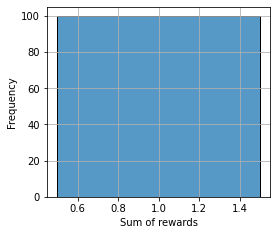

In [16]:
frozen.reset() # Reiniciamos el entorno

# Evaluación del agente entrenado 
episode = Episode(environment=frozen,\
                          env_name="Frozen",\
                          agent=agent,\
                          model_name='Q_Learning',\
                          num_rounds=200,\
                          state_interpreter=gym_interpreter1
                          )
df = episode.simulate(num_episodes=100,learn=False)
Plot(df).plot_histogram_rewards()

In [18]:
np.where((agent.policy) == 1)[1] #Obtenemos las acciones para cada estado

array([0, 0, 0, 1, 0, 3, 1, 1, 0, 1, 1, 2, 1, 1, 1, 3], dtype=int64)

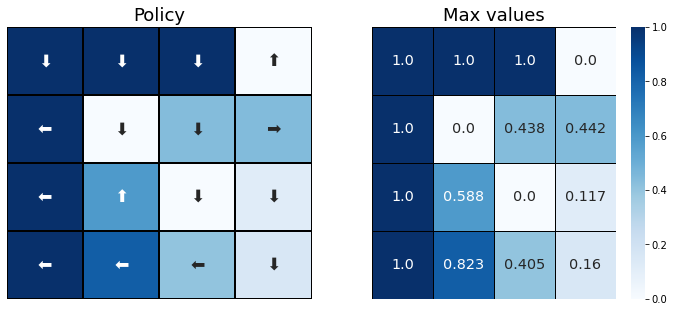

In [19]:
Q = []
for i in range(agent.nS):
    Q.append(round(agent.max_Q(i),3)) # Obtenemos el valor máximo de Q para cada estado
    
dict_acciones = {3:"⬆", 0:"⬅", 1:"⬇", 2:"➡"} # 0-Izquierda 1-Abajo 2-Derecha 3-Arriba
pp = PlotGridValues(shape=(4,4), dict_acciones=dict_acciones)

pp.plot_policy_and_values(np.where((agent.policy) == 1)[1].reshape(16),Q) # Graficamos la política y los valores de Q

---